### Copyright (C) Microsoft Corporation.  
see license.md file for Enterprise Customer License and ISV License details 

This consumes the api. Uses minimal docker config (non-GPU linux vm, see .yml file).

## Resources:
 - https://docs.microsoft.com/en-us/azure/machine-learning/preview/model-management-overview
 - https://docs.microsoft.com/en-us/azure/machine-learning/preview/model-management-configuration
 - https://docs.microsoft.com/en-us/azure/machine-learning/preview/deployment-setup-configuration
 - https://docs.microsoft.com/en-us/azure/machine-learning/preview/model-management-service-deploy
 - https://docs.microsoft.com/en-us/azure/machine-learning/preview/tutorial-classifying-iris-part-3

In [63]:
# Allow multiple displays per cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [64]:
import os
try:
    amlWBSharedDir = os.environ['AZUREML_NATIVE_SHARE_DIRECTORY']    
except:
    print( 'Not in amlwb? define amlWBSharedDir as "/shared_folder_on_host/amlwb_exp_acc/amlwb_work_space/amlwb_experiment"')
    amlWBSharedDir = ''
    
amlWBSharedDir

'/azureml-share/'

In [65]:
# # Use the Azure Machine Learning data collector to log various metrics
# from azureml.logging import get_azureml_logger
# logger = get_azureml_logger()

In [66]:
# Use Azure Machine Learning history magic to control history collection
# History is off by default, options are "on", "off", or "show"
# %azureml history on

In [67]:
# import utlity functions

import sys, os
paths_to_append = [os.path.join(os.getcwd(), os.path.join(*(['Code',  'src'])))]
def add_path_to_sys_path(path_to_append):
    if not (any(path_to_append in paths for paths in sys.path)):
        sys.path.append(path_to_append)

[add_path_to_sys_path(crt_path) for crt_path in paths_to_append]

import azure_chestxray_utils

[None]

In [68]:
# create the file path variables 

prj_consts = azure_chestxray_utils.chestxray_consts()
  
data_base_input_dir=os.path.join(amlWBSharedDir, 
                                 os.path.join(*(prj_consts.BASE_INPUT_DIR_list)))
nih_chest_xray_data_dir=os.path.join(data_base_input_dir, 
                                     os.path.join(*(prj_consts.ChestXray_IMAGES_DIR_list)))

nih_chest_xray_data_dir
chestXray_images=azure_chestxray_utils.get_files_in_dir(nih_chest_xray_data_dir)
len(chestXray_images)
chestXray_images[0]

test_images_dir=os.path.join(data_base_input_dir, 
    os.path.join(*(['test_images'])))
test_images_dir
test_images=azure_chestxray_utils.get_files_in_dir(test_images_dir)
len(test_images)
test_images[0]

'/azureml-share/chestxray/data/ChestX-ray8/ChestXray-NIHCC'

112120

'00002592_000.png'

'/azureml-share/chestxray/data/ChestX-ray8/test_images'

70

'00017802_001.png'

In [69]:
def as_string_b64encoded_pickled(input_object):
     #b64encode returns bytes class, make it string by calling .decode('utf-8')
     return (base64.b64encode(pickle.dumps(input_object))).decode('utf-8')

#FIXME this is an api specific value, used here and in service driver file score_iamge.py
# should be defined in one place and used by anything else
as_string_b64encoded_pickled_data_column_name   = 'encoded_image'

In [70]:
import cv2
import base64, pickle
import pandas as pd
import numpy as np
# cv2_image = cv2.imread(os.path.join(test_images_dir,test_images[5]))
cv2_image = cv2.imread(os.path.join(nih_chest_xray_data_dir,'00005066_030.png'))
cv2_image = cv2.resize(cv2_image,(224, 224)).astype(np.float32)
encoded_image = as_string_b64encoded_pickled(cv2_image)

In [71]:
import requests, json, time

scoring_url = 'http://40.68.153.194/api/v1/service/chestxraycamsrvc/score'
service_key = 'b2b40c834a324a888e09dac4766914e5'

try:
    scoring_url, service_key
except:
    print("ERROR: need to set 'cluster_scoring_url' and 'service_key' variables.")

headers = {'Content-Type': 'application/json'}
if service_key is not None and service_key is not []:
    headers['Authorization'] = 'Bearer ' + service_key
   

('http://40.68.153.194/api/v1/service/chestxraycamsrvc/score',
 'b2b40c834a324a888e09dac4766914e5')

In [72]:
data = '{"input_df": [{"'+as_string_b64encoded_pickled_data_column_name+'": "' + encoded_image + '"}]}'

In [73]:
res = requests.post(scoring_url, headers=headers, data=data)

In [74]:
type(res)
len(res.text)
response =json.loads(res.text)
response =json.loads(response)

requests.models.Response

71827

In [75]:
type(response)
len(response)
response.keys()


dict

2

dict_keys(['chestXrayScore', 'chestXrayCAM'])

In [76]:
def unpickled_b64decoded_as_bytes(input_object):
    if input_object.startswith('b\''):
        input_object = input_object[2:-1]
    # make string bytes
    input_object   =  input_object.encode('utf-8')
    #decode and the unpickle the bytes to recover original object
    return (pickle.loads(base64.b64decode(input_object)))

In [77]:
%matplotlib inline

(302, 294, 3)

(-0.5, 293.5, 301.5, -0.5)

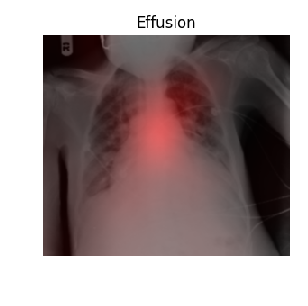

In [78]:
import numpy as np
serialized_cam_image = unpickled_b64decoded_as_bytes(response['chestXrayCAM'])
file_bytes = np.asarray(bytearray(serialized_cam_image.read()), dtype=np.uint8)
recovered_image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
recovered_image.shape

import matplotlib.pyplot as plt
fig = plt.figure(figsize = (5,5))
# RGB to GBR because of opencv to matplotlib incompatibilities
plt.imshow(recovered_image[...,[2,0,1]]);plt.axis('off')

In [79]:
# get bbox data

other_data_dir=os.path.join(data_base_input_dir, os.path.join(*(prj_consts.ChestXray_OTHER_DATA_DIR_list)))
other_data_dir
# !mkdir -p {other_data_dir}
!ls $other_data_dir

all_bbox_data = pd.read_csv(os.path.join(other_data_dir, 'BBox_List_2017.csv'))

# show some stats
# for tallying, collections lib is faster than list comprehension
from collections import Counter
pathologies_distribution = Counter(list(all_bbox_data['Finding Label']))
pathologies_distribution = sorted(pathologies_distribution.items(), key=lambda x: x[1], reverse=True)

pathologies_distribution

# define a list of pathologies
crt_pathology_name_group = list(['Atelectasis', 'Effusion', \
                        'Cardiomegaly', 'Nodule'])
crt_pathology_name = str(crt_pathology_name_group[3])
crt_pathology_name
crt_pathology_image_file_names = \
all_bbox_data[all_bbox_data['Finding Label'].isin(list([crt_pathology_name]))]['Image Index']
crt_pathology_image_file_names[:5]

'/azureml-share/chestxray/data/ChestX-ray8/ChestXray-NIHCC_other'

BBox_List_2017.csv  Data_Entry_2017.csv  blacklist.csv


[('Atelectasis', 180),
 ('Effusion', 153),
 ('Cardiomegaly', 146),
 ('Infiltrate', 123),
 ('Pneumonia', 120),
 ('Pneumothorax', 98),
 ('Mass', 85),
 ('Nodule', 79)]

'Nodule'

668    00001688_000.png
669    00004547_003.png
670    00023078_000.png
671    00023068_003.png
672    00013911_000.png
Name: Image Index, dtype: object

00001688_000.png
00004547_003.png
00023078_000.png


[None, None, None]

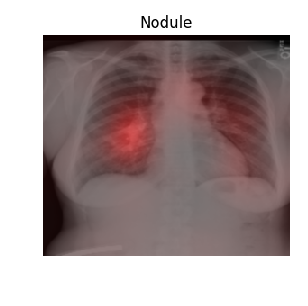

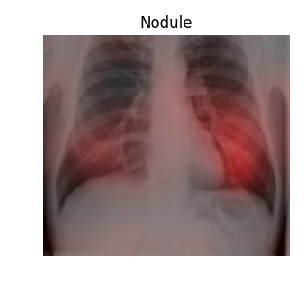

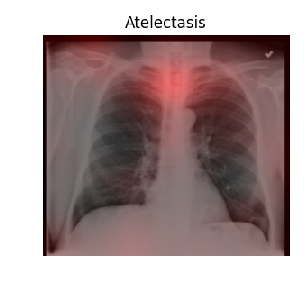

In [80]:
def score_image(crt_pathology_images_dir, crt_pathology_image_file_name):
    print(crt_pathology_image_file_name)
    crt_image = cv2.imread(os.path.join(crt_pathology_images_dir,crt_pathology_image_file_name))
    crt_image = cv2.resize(crt_image,(224, 224)).astype(np.float32)
    crt_encoded_image = as_string_b64encoded_pickled(crt_image)
    crt_data = '{"input_df": [{"'+as_string_b64encoded_pickled_data_column_name+'": "' + crt_encoded_image + '"}]}'
    res = requests.post(scoring_url, headers=headers, data=crt_data)
    response =json.loads(json.loads(res.text))

    serialized_cam_image = unpickled_b64decoded_as_bytes(response['chestXrayCAM'])
    file_bytes = np.asarray(bytearray(serialized_cam_image.read()), dtype=np.uint8)
    recovered_image = cv2.imdecode(file_bytes, cv2.IMREAD_COLOR)
    import matplotlib.pyplot as plt
    fig = plt.figure(figsize = (5,5))
    # RGB to GBR because of opencv to matplotlib incompatibilities
    plt.imshow(recovered_image[...,[2,0,1]]);plt.axis('off')

[score_image(nih_chest_xray_data_dir, crt_image) for crt_image in crt_pathology_image_file_names[:3]]

In [81]:
# jupyter nbconvert --to html .\Code\03_Deployment\000_test_cam_api.ipynb
